## Wavefunctions representation 

We are aiming to plot the wavefunctions associated to the following hamiltonian :

$$\hat{H} = 4 E_C \hat{n}^2 + \frac{E_L}{2} (\hat{\phi}-\phi_{ext})^2 - E_J \cos(\hat{\phi})$$

With the diagonalization of the hamiltonian written in the fock basis, the coefficient of the eigenvectors gives us :

$$|\psi_i\rangle = \sum^{cutoff}_{j=1} c_{ij}|j\rangle$$

With this expression, it's easy to project on the phase basis as we know the expression of the projection of the fock states on the phase basis :

$$\langle \phi \mid n \rangle
=
\frac{1}{\pi^{1/4}\sqrt{2^{n}n!}}
\frac{1}{\sqrt{\phi_{\mathrm{zpf}}}}
H_n\!\left(\frac{\phi}{\phi_{\mathrm{zpf}}}\right)
\exp\!\left[-\frac{\phi^2}{2\phi_{\mathrm{zpf}}^2}\right]
$$

Then, we will be able to plot the different wavefunctions

In [128]:
from math import factorial, pi, sqrt

import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import expm
from scipy.special import eval_hermite


In [129]:
def Hamiltonian_numpy1(flux_ext = 0, EJ=8.9, EC=2.5, EL=0.5, cutoff=110):

    n_zpf = (EL / (32 * EC)) ** 0.25
    phi_zpf = 1 / (2 * n_zpf)

    a = np.zeros((cutoff, cutoff))
    for i in range(cutoff - 1):
        a[i][i + 1] = np.sqrt(i + 1)
    a_dag = a.conj().transpose()

    phi_op = phi_zpf * (a + a_dag)
    n_op = (1j / (2 * phi_zpf)) * (a_dag - a)

    H_C = 4 * EC * (n_op @ n_op)

    phi_shifted = phi_op - flux_ext * np.eye(cutoff)
    H_L = 0.5 * EL * (phi_shifted @ phi_shifted)

    exp_i_phi = expm(1j * phi_op)
    cos_phi_op = 0.5 * (exp_i_phi + exp_i_phi.conj().T)
    H_J = -EJ * cos_phi_op

    return H_C + H_L + H_J

In [130]:
def Hamiltonian_numpy(flux_ext = 0, EJ=8.9, EC=2.5, EL=0.5, cutoff=110):

    n_zpf = (EL / (32 * EC)) ** 0.25
    phi_zpf = 1 / (2 * n_zpf)

    a = np.zeros((cutoff, cutoff))
    for i in range(cutoff - 1):
        a[i][i + 1] = np.sqrt(i + 1)
    a_dag = a.conj().transpose()

    phi_op = phi_zpf * (a + a_dag)
    n_op = (1j / (2 * phi_zpf)) * (a_dag - a)

    H_C = 4 * EC * (n_op @ n_op)

    phi = phi_op + flux_ext * np.eye(cutoff)
    H_L = 0.5 * EL * (phi_op @ phi_op)

    exp_i_phi = expm(1j * phi)
    cos_phi = 0.5 * (exp_i_phi + exp_i_phi.conj().T)
    H_J = -EJ * cos_phi

    return H_C + H_L + H_J

In [131]:
def potential(phi, flux_ext = 0,EL = 0.5,EJ=8.9):
    return EL/2 * (phi-flux_ext)**2 - EJ * np.cos(phi)

In [132]:
def eigen_vectors_numpy(N_eigen, flux_ext = 0, EJ=8.9, EC=2.5, EL=0.5, cutoff=110):
    H = Hamiltonian_numpy(flux_ext, EJ, EC, EL, cutoff)

    eigvals, eigvecs = np.linalg.eigh(H)

    return eigvecs[:, :N_eigen], eigvals[:N_eigen]

In [133]:
def fock_phase_projection(n, phi, phi_zpf=1):
    x = phi/phi_zpf
    norm = 1/(pi**0.25*sqrt(2**n*factorial(n))*np.sqrt(phi_zpf))
    return norm * eval_hermite(n, x) * np.exp(-x**2/2)

def vector_projection(Vec,phi,phi_zpf):
    Res = 0
    for i in range(np.shape(Vec)[0]):
        Res += Vec[i] * fock_phase_projection(i,phi,phi_zpf)
    return Res

In [134]:
from matplotlib.ticker import MultipleLocator

In [154]:
def plot_wavefunctions(N_eigen, flux_ext = 0, EJ=8.9, EC=2.5, EL=0.5, cutoff=110):

    n_zpf = (EL / (32 * EC)) ** 0.25
    phi_zpf = 1/(2*n_zpf)

    eig_vec = eigen_vectors_numpy(N_eigen, flux_ext, EJ, EC, EL, cutoff)[0]
    PHI = np.linspace(-3 * np.pi,3*np.pi, 500)
    Res = np.zeros((np.shape(PHI)[0],N_eigen))
    potential_l = np.zeros(np.shape(PHI)[0])
    for i in range(np.shape(PHI)[0]):
        for j in range(N_eigen):
            Res[i][j] = np.abs(vector_projection(eig_vec[:,j],PHI[i]-flux_ext,phi_zpf))**2
        potential_l[i] = potential(PHI[i], flux_ext,EL,EJ)
    
    fig, ax = plt.subplots(1,1)
    for j in range(N_eigen):
        ax.plot(PHI,Res[:,j], label = f'Energie {j}')
    ax.set(xlabel = r'$\phi [rad]$', ylabel = r'$\psi_n (\phi)$')
    ticks = np.arange(-3, 4) * np.pi
    labels = [rf"${i}\pi$" if i != 0 else r"$0$" for i in range(-3, 4)]

    ax.plot(PHI,potential_l/np.max(potential_l),'r-',label = 'Potential')

    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.legend(title=rf"$\phi_{{\mathrm{{ext}}}} = {round(flux_ext / np.pi,1)} \pi$")
    plt.show()

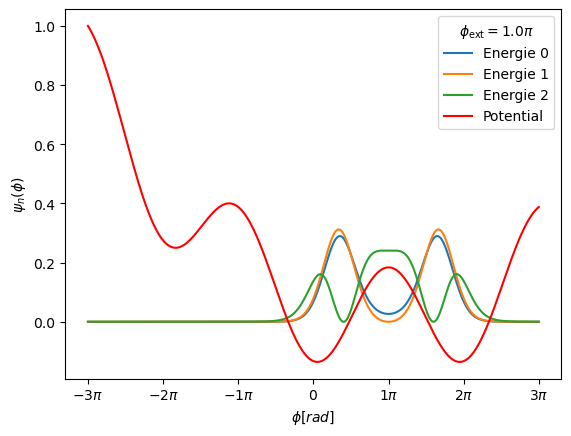

In [155]:
plot_wavefunctions(3,flux_ext = np.pi,cutoff = 120)

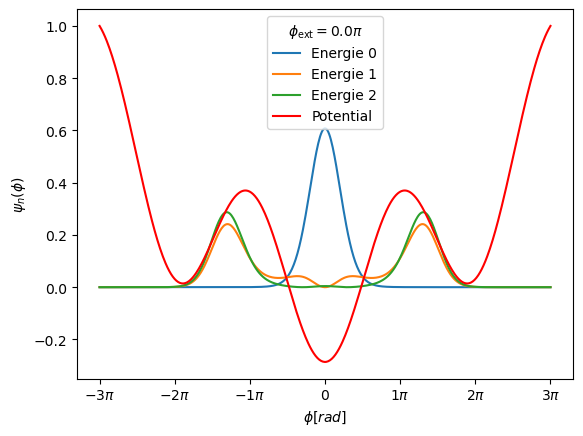

In [156]:
plot_wavefunctions(3,flux_ext = 0,cutoff = 120)